In [9]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.model_selection import train_test_split
import os
import shutil
from multiprocessing import Pool, get_context

import dlib
from PIL import Image


### Combining the two CSVs

In [ ]:
# Define input CSV files
csv_files = ["all-age-faces/all-age-metadata.csv", "UTKface_inthewild/UTKface_metadata.csv"]

# Define output CSV file
combined_csv_file = "image-metadata.csv"

# Columns to keep (filename, age, gender)
columns_to_keep = [0, 1, 2]

# Merge CSV files
merged_data = []
for file in csv_files:
    with open(file, 'r', newline='') as infile:
        reader = csv.reader(infile)
        # Skip the header row
        next(reader, None)
        # Read CSV data into a list of lists, selecting specified columns
        data = [[row[i] for i in columns_to_keep] for row in reader]
        # Append to merged_data
        merged_data.extend(data)

# Write merged data to the output CSV file
with open(combined_csv_file, 'w', newline='') as outfile:
    writer = csv.writer(outfile)
    # Write header
    writer.writerow(["filename", "age", "gender"])
    # Write merged data
    writer.writerows(merged_data)

print("Combined CSV file created with specified columns.")



### Combined Data Visualisation

In [11]:
# Read the combined metadata CSV file into a DataFrame
combined_csv_file = 'image-metadata.csv'
metadata_df = pd.read_csv(combined_csv_file)


metadata_df.head()

,filename,age,gender
0,06800A60.jpg,60,female
1,05689A43.jpg,43,female
2,03865A32.jpg,32,female
3,08580A23.jpg,23,male
4,09385A29.jpg,29,male


In [12]:
# Set style
plt.style.use('Solarize_Light2')

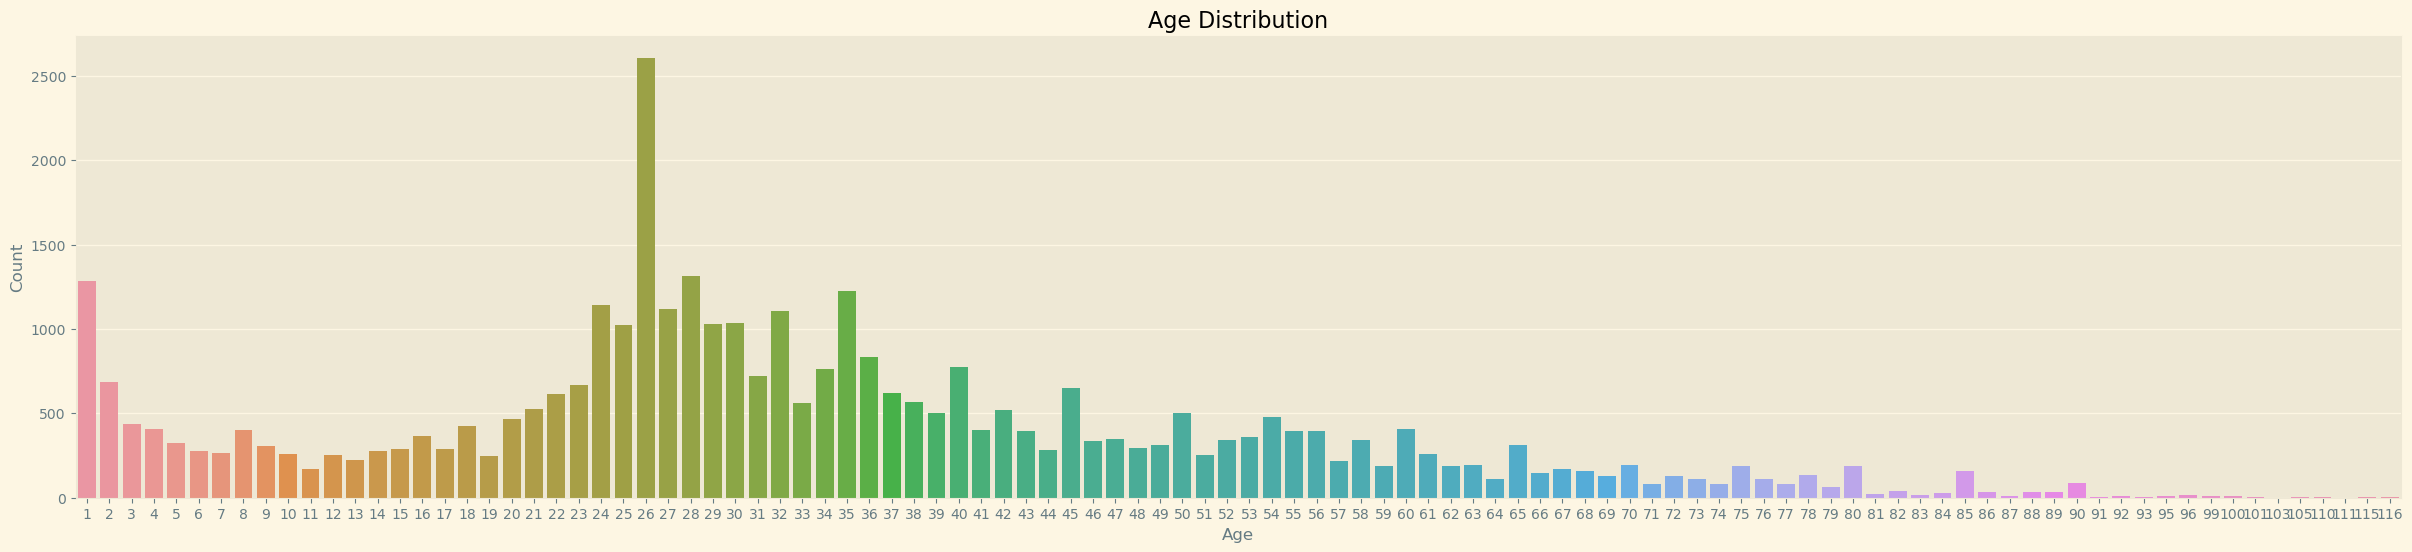

In [13]:
plt.figure(figsize=(30, 6))
sns.countplot(data=metadata_df, x='age')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

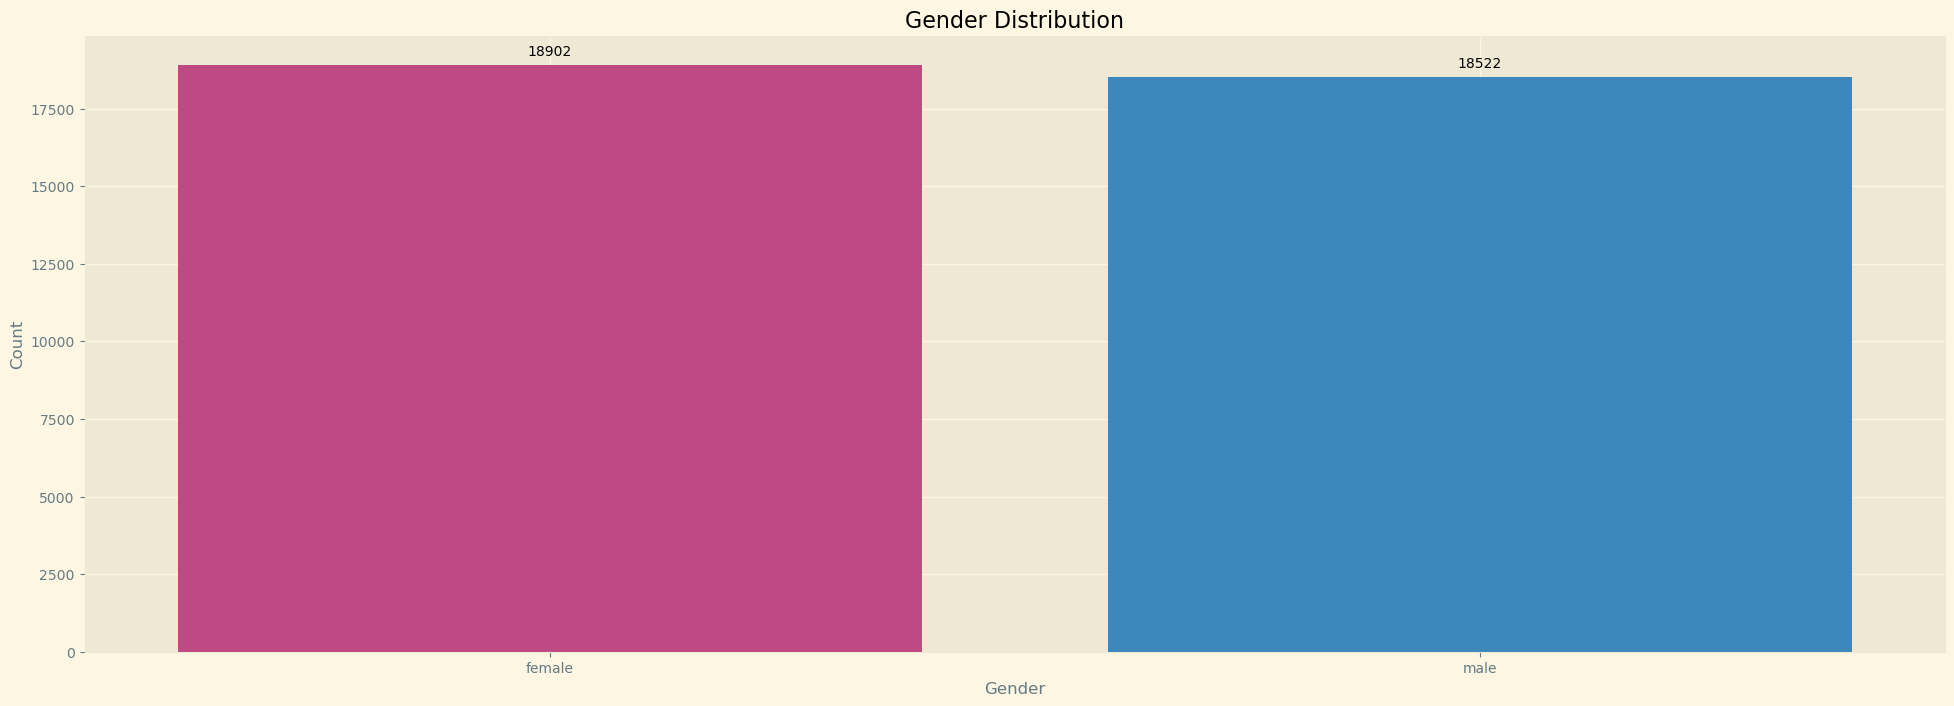

In [14]:
# Define custom color palette
custom_palette = {'male': '#268bd2', 'female': '#d33682'}

# Visualize gender distribution with custom colors
plt.figure(figsize=(24, 8))
ax = sns.countplot(data=metadata_df, x='gender', palette=custom_palette)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.grid(True)

# Adding counts on top of bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'bottom', 
                   xytext = (0, 5), 
                   textcoords = 'offset points',
                   fontsize=10)

plt.show()

### Data Sampling

To ensure a balanced dataset, we aim to distribute the data from both sources, to achieve one that resembles our population's age and gender distribution. In this case, we will be mirroring it in the context of Singapore, with the statistics from [SingStat](https://tablebuilder.singstat.gov.sg/table/TS/M810011#!).

##### Finding Population Distribution


In [15]:
singstat_df = pd.read_csv("singstat.csv", skiprows=10, nrows=75, usecols=[0, 1])
print(singstat_df)

          Data Series    2023 
0     Total Residents  4149253
1         0 - 4 Years   175268
2         5 - 9 Years   201974
3       10 - 14 Years   204459
4       15 - 19 Years   209579
..                ...      ...
70    70 Years & Over   254692
71    75 Years & Over   151651
72    80 Years & Over    85814
73    85 Years & Over    41300
74    90 Years & Over    16464

[75 rows x 2 columns]


In [16]:
### Split into 3 dataframes - for all, female, male

# Find the index positions of the categories
total_residents_index = singstat_df[singstat_df['Data Series'] == 'Total Residents'].index[0]
total_male_residents_index = singstat_df[singstat_df['Data Series'] == 'Total Male Residents'].index[0]
total_female_residents_index = singstat_df[singstat_df['Data Series'] == 'Total Female Residents'].index[0]

# Split the DataFrame based on the categories
total_residents_df = singstat_df[total_residents_index:total_male_residents_index]
total_male_residents_df = singstat_df[total_male_residents_index:total_female_residents_index]
total_female_residents_df = singstat_df[total_female_residents_index:]

### Combine into one table
population_df = total_residents_df.merge(total_male_residents_df, on='Data Series').merge(total_female_residents_df, on='Data Series')
population_df.columns = ['Category', 'Total', 'Male', 'Female']

population_df = population_df.drop(index=range(18, 23))

population_df



,Category,Total,Male,Female
0,0 - 4 Years,175268,89629,85639
1,5 - 9 Years,201974,103249,98725
2,10 - 14 Years,204459,104335,100124
3,15 - 19 Years,209579,106461,103118
4,20 - 24 Years,229066,116897,112169
5,25 - 29 Years,277889,138511,139378
6,30 - 34 Years,323627,156440,167187
7,35 - 39 Years,300037,141580,158457
8,40 - 44 Years,310173,146677,163496
9,45 - 49 Years,302515,145297,157218


##### Normalizing proportions + calculating distribution


In [17]:
# Normalize the population statistics to obtain proportions
total_population = population_df['Total'].sum()
population_df['Total_Proportion'] = population_df['Total'] / total_population
population_df['male_Proportion'] = population_df['Male'] / total_population
population_df['female_Proportion'] = population_df['Female'] / total_population

population_df

,Category,Total,Male,Female,Total_Proportion,male_Proportion,female_Proportion
0,0 - 4 Years,175268,89629,85639,0.042241,0.021601,0.020640
1,5 - 9 Years,201974,103249,98725,0.048677,0.024884,0.023793
2,10 - 14 Years,204459,104335,100124,0.049276,0.025145,0.024131
3,15 - 19 Years,209579,106461,103118,0.050510,0.025658,0.024852
4,20 - 24 Years,229066,116897,112169,0.055207,0.028173,0.027034
5,25 - 29 Years,277889,138511,139378,0.066973,0.033382,0.033591
6,30 - 34 Years,323627,156440,167187,0.077996,0.037703,0.040293
7,35 - 39 Years,300037,141580,158457,0.072311,0.034122,0.038189
8,40 - 44 Years,310173,146677,163496,0.074754,0.035350,0.039404
9,45 - 49 Years,302515,145297,157218,0.072908,0.035018,0.037891


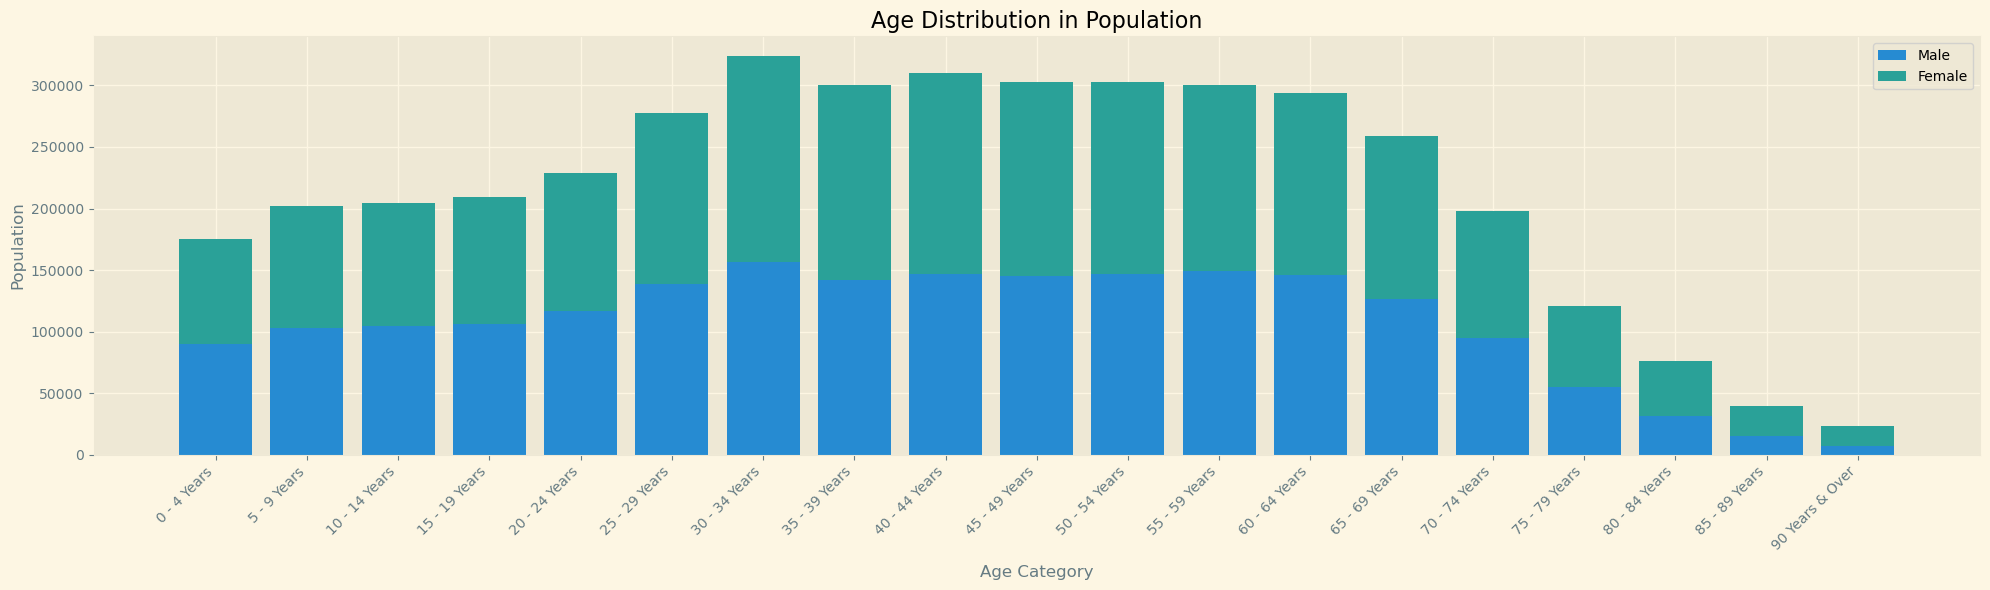

In [18]:
# Plotting age distribution of singapores population
plt.figure(figsize=(20, 6))

# Plotting males
plt.bar(population_df['Category'], population_df['Male'], label='Male')

# Plotting females on top of males
plt.bar(population_df['Category'], population_df['Female'], bottom=population_df['Male'], label='Female')

plt.xlabel('Age Category')
plt.ylabel('Population')
plt.title('Age Distribution in Population')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

#### Preparing our dataset to be sampled

In [19]:
# Read your dataset
dataset_df = pd.read_csv("image-metadata.csv")

# Define a function to determine the age group based on age value
def determine_age_group(age):
    if age < 5:
        return '0 - 4 Years'
    elif age < 10:
        return '5 - 9 Years'
    elif age < 15:
        return '10 - 14 Years'
    elif age < 20:
        return '15 - 19 Years'
    elif age < 25:
        return '20 - 24 Years'
    elif age < 30:
        return '25 - 29 Years'
    elif age < 35:
        return '30 - 34 Years'
    elif age < 40:
        return '35 - 39 Years'
    elif age < 45:
        return '40 - 44 Years'
    elif age < 50:
        return '45 - 49 Years'
    elif age < 55:
        return '50 - 54 Years'
    elif age < 60:
        return '55 - 59 Years'
    elif age < 65:
        return '60 - 64 Years'
    elif age < 70:
        return '65 - 69 Years'
    elif age < 75:
        return '70 - 74 Years'
    elif age < 80:
        return '75 - 79 Years'
    elif age < 85:
        return '80 - 84 Years'
    elif age < 90:
        return '85 - 89 Years'
    else:
        return '90 Years & Over'

# Apply the function to create the 'Category' column
dataset_df['Category'] = dataset_df['age'].apply(determine_age_group)

def convert_age_group(age_group):
    age_group = age_group.replace("Years", "").replace("& Over", "").strip()
    return age_group

dataset_df['Category'] = dataset_df['Category'].apply(convert_age_group)
population_df['Category'] = population_df['Category'].apply(convert_age_group)



# Display the modified DataFrame
dataset_df



,filename,age,gender,Category
0,06800A60.jpg,60,female,60 - 64
1,05689A43.jpg,43,female,40 - 44
2,03865A32.jpg,32,female,30 - 34
3,08580A23.jpg,23,male,20 - 24
4,09385A29.jpg,29,male,25 - 29
...,...,...,...,...
37419,26_0_3_20170119180536092.jpg,26,male,25 - 29
37420,58_0_3_20170119211538977.jpg,58,male,55 - 59
37421,64_0_0_20170120222811411.jpg,64,male,60 - 64
37422,54_0_3_20170119210221456.jpg,54,male,50 - 54


In [20]:
# Check the current distribution in compiled dataset



# Group by age group and gender, then count occurrences
age_gender_count = dataset_df.groupby(['Category', 'gender']).size().reset_index(name='count')

# Pivot the DataFrame to get malecount and femalecount columns
data_distribution = age_gender_count.pivot_table(index='Category', columns='gender', values='count', aggfunc='sum').reset_index()

# Fix sorting with temp var
data_distribution['Sort_Order'] = data_distribution['Category'].str.extract('(\d+)').astype(int)
data_distribution = data_distribution.sort_values(by='Sort_Order')
data_distribution.drop(columns=['Sort_Order'], inplace=True)


# Rename the columns
data_distribution.columns.name = None  # Remove the 'gender' label
data_distribution.columns = ['Category', 'Male_count', 'Female_count']
total_samples_current=dataset_df.shape[0]
data_distribution[['Male_count', 'Female_count']]


data_distribution

,Category,Male_count,Female_count
0,0 - 4,1451,1358
9,5 - 9,870,702
1,10 - 14,639,542
2,15 - 19,935,676
3,20 - 24,2319,1100
4,25 - 29,4098,2993
5,30 - 34,2130,2058
6,35 - 39,1706,2047
7,40 - 44,1061,1309
8,45 - 49,739,1210


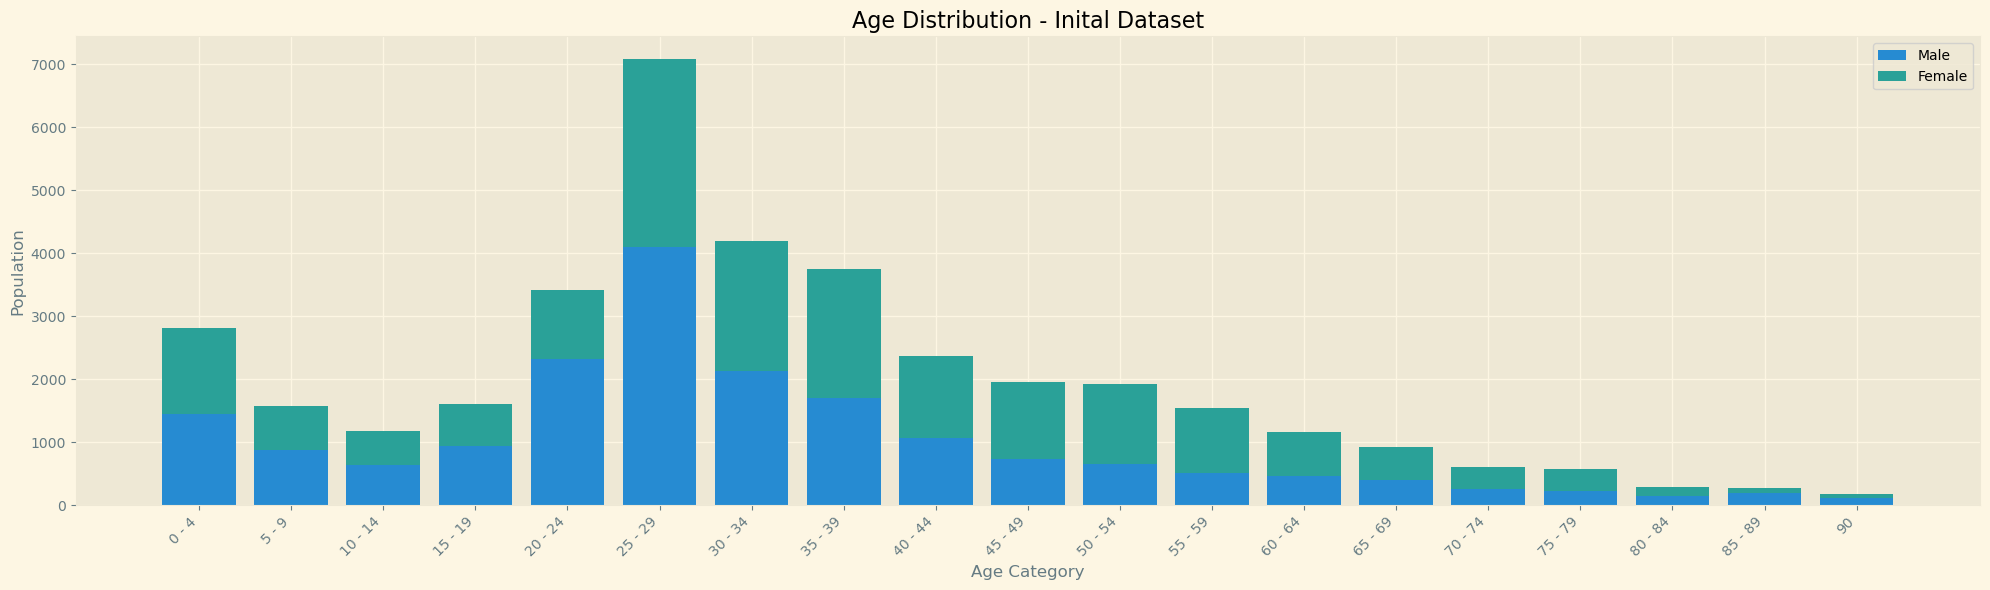

In [21]:
# Plotting
plt.figure(figsize=(20, 6))


# Fix sorting with temp var
data_distribution['Sort_Order'] = data_distribution['Category'].str.extract('(\d+)').astype(int)
data_distribution = data_distribution.sort_values(by='Sort_Order')
data_distribution.drop(columns=['Sort_Order'], inplace=True)


# Plotting males
plt.bar(data_distribution['Category'], data_distribution['Male_count'], label='Male')

# Plotting females on top of males
plt.bar(data_distribution['Category'], data_distribution['Female_count'], bottom=data_distribution['Male_count'], label='Female')

plt.xlabel('Age Category')
plt.ylabel('Population')
plt.title('Age Distribution - Inital Dataset')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

#### Sampling the dataset

In [22]:
# Calculate the total number of samples needed to match the population distribution
total_samples = len(dataset_df)
target_samples = (population_df['Total_Proportion'] * total_samples).astype(int)

downsampled_df = pd.DataFrame(columns=dataset_df.columns)

# Downsample each category to match the target distribution
for category, target_count in zip(population_df['Category'], target_samples):
    category_df = dataset_df[dataset_df['Category'] == category]
    sampled_df = category_df.sample(n=target_count, replace=True) if len(category_df) < target_count else category_df.sample(n=target_count, replace=False)
    downsampled_df = pd.concat([downsampled_df, sampled_df])

downsampled_df = downsampled_df.sample(frac=1).reset_index(drop=True)

downsampled_df

,filename,age,gender,Category
0,13176A75.jpg,75,male,75 - 79
1,00406A07.jpg,7,female,5 - 9
2,4_1_3_20161219225734881.jpg,4,female,0 - 4
3,05066A39.jpg,39,female,35 - 39
4,02587A27.jpg,27,female,25 - 29
...,...,...,...,...
37409,65_0_2_20170112205504482.jpg,65,male,65 - 69
37410,61_0_0_20170120225132849.jpg,61,male,60 - 64
37411,10509A36.jpg,36,male,35 - 39
37412,61_0_0_20170117174441717.jpg,61,male,60 - 64


##### Visualisation of our sampled dataset


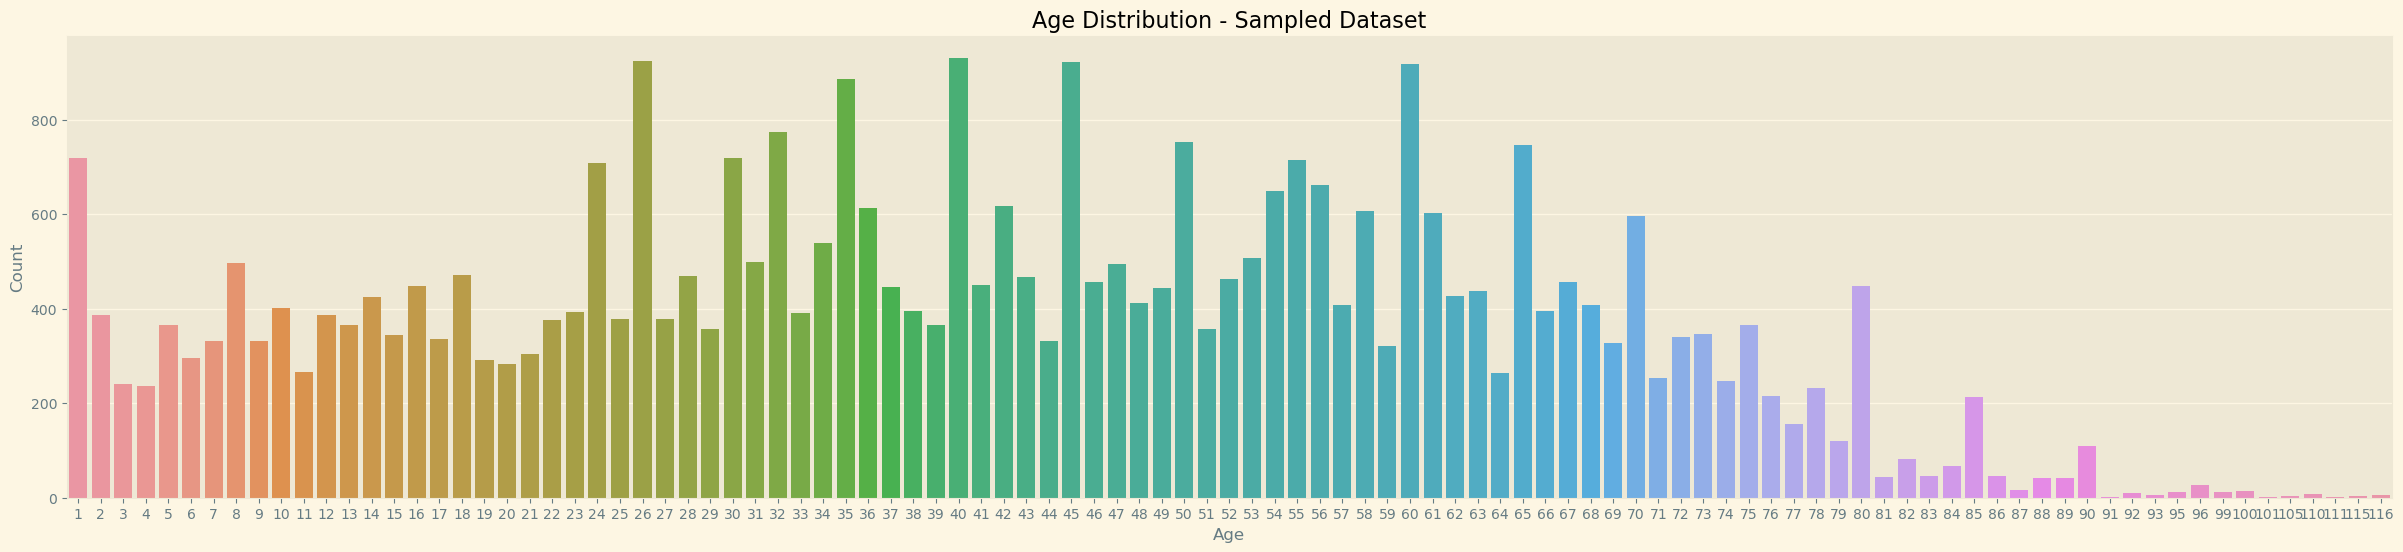

In [23]:

plt.figure(figsize=(30, 6))
sns.countplot(data=downsampled_df, x='age')
plt.title('Age Distribution - Sampled Dataset')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

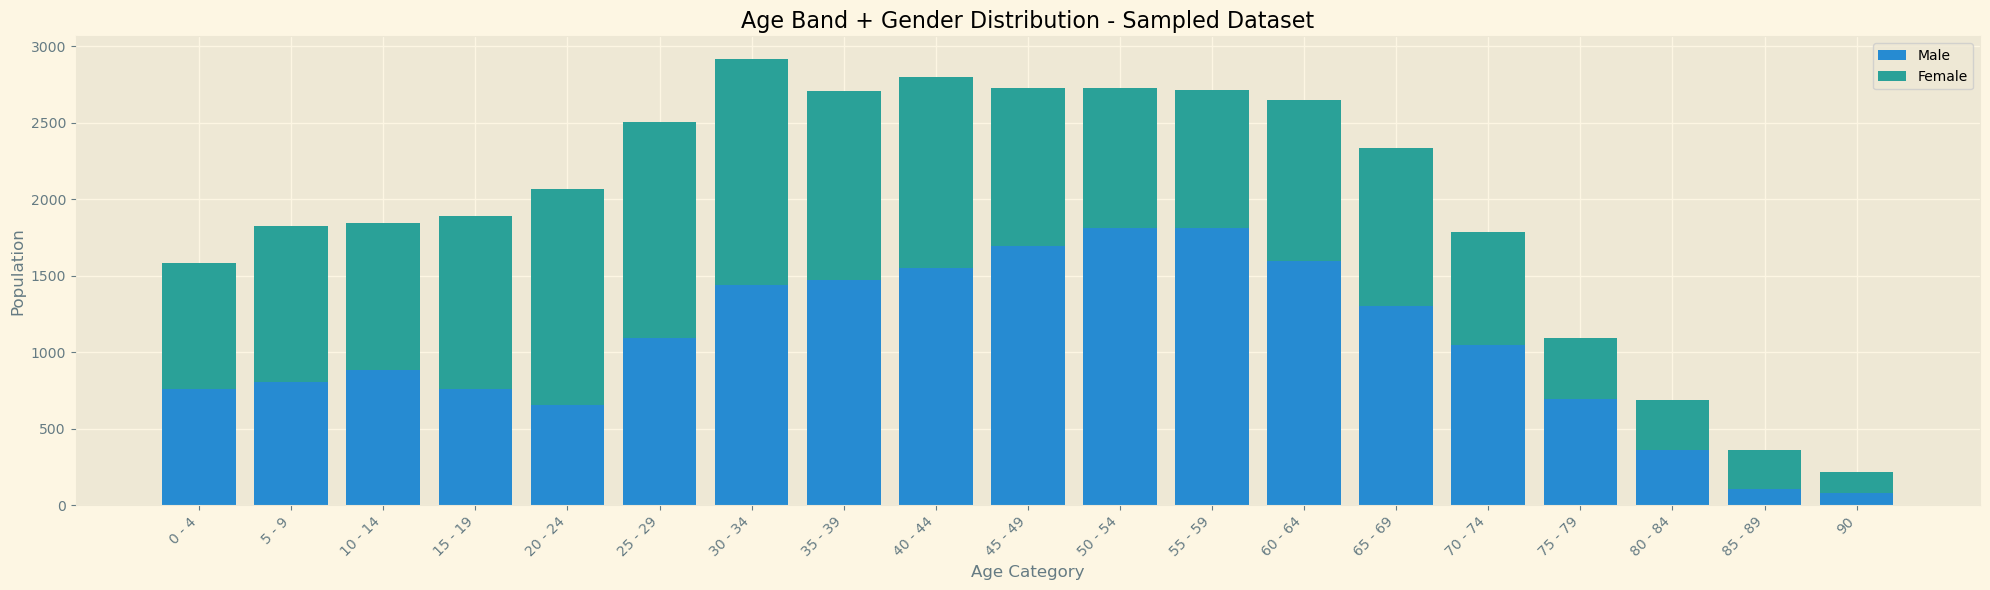

In [24]:
# Plotting
plt.figure(figsize=(20, 6))

# Proper sorting
age_band_counts = downsampled_df.groupby(['Category', 'gender']).size().unstack(fill_value=0)
age_band_counts['Sort_Order'] = age_band_counts.index.map(lambda x: int(x.split(' - ')[0]))
age_band_counts = age_band_counts.sort_values(by='Sort_Order')
age_band_counts.drop(columns=['Sort_Order'], inplace=True)

# Plotting males
plt.bar(age_band_counts.index, age_band_counts['male'], label='Male')

# Plotting females on top of males
plt.bar(age_band_counts.index, age_band_counts['female'], bottom=age_band_counts['male'], label='Female')

plt.xlabel('Age Category')
plt.ylabel('Population')
plt.title('Age Band + Gender Distribution - Sampled Dataset')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

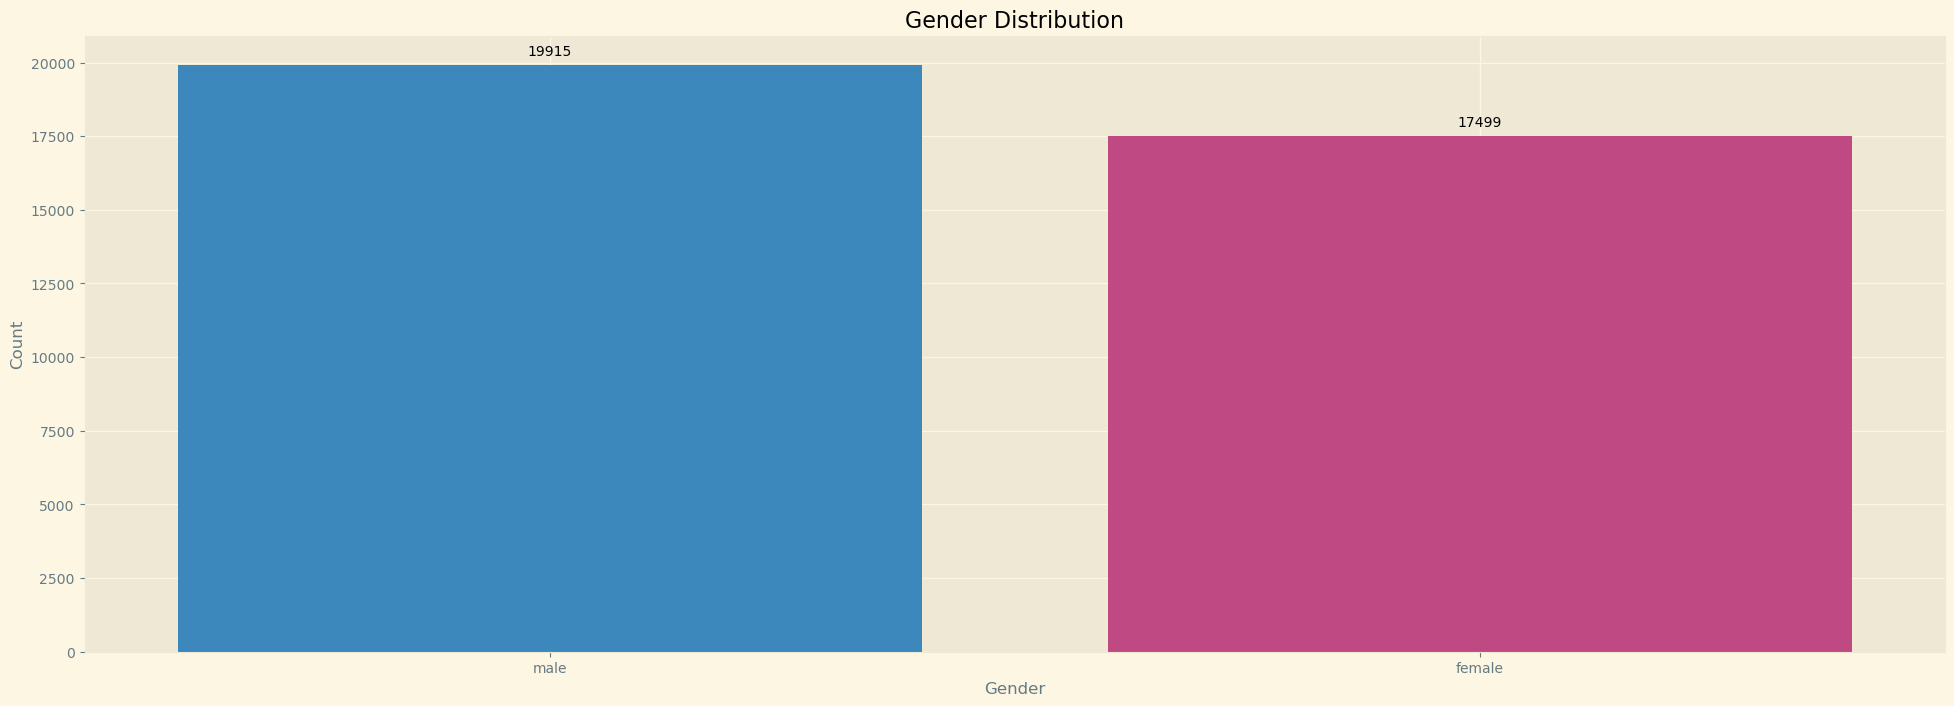

In [25]:
# Visualize gender distribution with custom colors
plt.figure(figsize=(24, 8))
ax = sns.countplot(data=downsampled_df, x='gender', palette=custom_palette)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.grid(True)

# Adding counts on top of bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'bottom', 
                   xytext = (0, 5), 
                   textcoords = 'offset points',
                   fontsize=10)

plt.show()

### Split Dataset - Training, Testing, Validation

In [26]:
#export downsampled df as a csv
downsampled_df_without_category = downsampled_df.drop(columns=['Category'])
downsampled_df_without_category.to_csv("sampled_metadata.csv", index=False)

In [27]:
from sklearn.model_selection import train_test_split

# Initialize empty DataFrames for each split
train_data = pd.DataFrame(columns=downsampled_df.columns)
test_data = pd.DataFrame(columns=downsampled_df.columns)
val_data = pd.DataFrame(columns=downsampled_df.columns)

# Splitting the dataset for each gender and age category
for gender in downsampled_df['gender'].unique():
    for category in downsampled_df['Category'].unique():
        # Select data for current gender and age category
        subset = downsampled_df[(downsampled_df['gender'] == gender) & (downsampled_df['Category'] == category)]
        
        # Splitting the subset into training, testing, and validation sets
        train_subset, test_val_subset = train_test_split(subset, test_size=0.2, random_state=42)
        test_subset, val_subset = train_test_split(test_val_subset, test_size=0.5, random_state=42)
        
        # Concatenating the split subsets to the corresponding split DataFrames
        train_data = pd.concat([train_data, train_subset])
        test_data = pd.concat([test_data, test_subset])
        val_data = pd.concat([val_data, val_subset])

# Ensure no dataset is repeated
assert len(train_data) == len(train_data.index.unique())
assert len(test_data) == len(test_data.index.unique())
assert len(val_data) == len(val_data.index.unique())

# Display the shapes of the split datasets
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)
print("Validation data shape:", val_data.shape)

# Export the split datasets to CSV files
train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)


Training data shape: (29913, 4)
Testing data shape: (3739, 4)
Validation data shape: (3762, 4)


In [35]:
# Function to create folders and copy files
def copy_files_from_csv(csv_file, source_dirs):
    # Read CSV file
    df = pd.read_csv(csv_file)
    
    # Create folder with the same name as CSV file
    folder_name = os.path.splitext(os.path.basename(csv_file))[0]
    dest_folder = os.path.join(os.getcwd(), folder_name)
    os.makedirs(dest_folder, exist_ok=True)
    
    # Copy files listed in CSV to the destination folder
    for index, row in df.iterrows():
        for source_dir in source_dirs:
            source_file = os.path.join(source_dir, row['filename'])
            if os.path.exists(source_file):
                destination_file = os.path.join(dest_folder, row['filename'])
                shutil.copy(source_file, destination_file)
                break  # Move to the next filename

# Define source directories
source_dirs = ["UTKface_inthewild/part1", "UTKface_inthewild/part2", "UTKface_inthewild/part3", "all-age-faces/data/original images"]

# Copy files for train data
copy_files_from_csv("train_data.csv", source_dirs)

# Copy files for test data
copy_files_from_csv("test_data.csv", source_dirs)

# Copy files for validation data
copy_files_from_csv("val_data.csv", source_dirs)



### Image Preprocessing
This includes detecting the faces and cropping the images within the train, test, val folderes.

In [38]:
# Load the dlib face detector
detector = dlib.get_frontal_face_detector()

# Function to detect and crop faces with margin using dlib
def detect_and_crop_faces_dlib(image, margin=20):
    faces = detector(image, 1)
    
    cropped_faces = []
    for face in faces:
        x1, y1, x2, y2 = face.left(), face.top(), face.right(), face.bottom()
        x_margin = max(0, x1 - margin)
        y_margin = max(0, y1 - margin)
        cropped_faces.append(image[y_margin:y2+margin, x_margin:x2+margin])
    
    return cropped_faces

# Function to normalize images
def normalize_image(image):
    return image / 255.0

# Process images in folder and replace them with preprocessed ones
def preprocess_images_in_folder(source_folder):
    for filename in os.listdir(source_folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(source_folder, filename)
            image = np.array(Image.open(image_path))
            
            # Check if image has at least two dimensions
            if len(image.shape) < 2:
                print(f"Skipping {filename} due to unsupported format.")
                continue
            
            # Convert image to RGB format if not already in that format
            if len(image.shape) == 3 and image.shape[2] != 3:
                image = Image.open(image_path).convert("RGB")
                image = np.array(image)
            
            print(f"Processing {filename}...")
            cropped_faces = detect_and_crop_faces_dlib(image)
            for i, face in enumerate(cropped_faces):
                normalized_face = normalize_image(face)
                Image.fromarray((normalized_face * 255.0).astype(np.uint8)).save(image_path)
            print(f"Finished processing {filename}.")

# Define source folders
source_train_folder = "train_data"
source_test_folder = "test_data"
source_val_folder = "val_data"


In [39]:
preprocess_images_in_folder(source_test_folder)

Processing 32_1_0_20170117134803913.jpg...
Finished processing 32_1_0_20170117134803913.jpg.
Processing 05992A46.jpg...
Finished processing 05992A46.jpg.
Processing 12385A55.jpg...
Finished processing 12385A55.jpg.
Processing 05750A44.jpg...
Finished processing 05750A44.jpg.
Processing 53_0_0_20170117190930257.jpg...
Finished processing 53_0_0_20170117190930257.jpg.
Processing 85_1_0_20170120222635457.jpg...
Finished processing 85_1_0_20170120222635457.jpg.
Processing 11496A44.jpg...
Finished processing 11496A44.jpg.
Processing 17_0_0_20170104230556561.jpg...
Finished processing 17_0_0_20170104230556561.jpg.
Processing 25_1_2_20170116175243754.jpg...
Finished processing 25_1_2_20170116175243754.jpg.
Processing 12588A58.jpg...
Finished processing 12588A58.jpg.
Processing 11968A49.jpg...
Finished processing 11968A49.jpg.
Processing 57_0_0_20170105173447996.jpg...
Finished processing 57_0_0_20170105173447996.jpg.
Processing 78_1_0_20170120225556721.jpg...
Finished processing 78_1_0_201701

In [40]:
preprocess_images_in_folder(source_val_folder)

Processing 16_1_3_20170104222158160.jpg...
Finished processing 16_1_3_20170104222158160.jpg.
Processing 40_1_0_20170105172927477.jpg...
Finished processing 40_1_0_20170105172927477.jpg.
Processing 09385A29.jpg...
Finished processing 09385A29.jpg.
Processing 21_0_4_20161223214759249.jpg...
Finished processing 21_0_4_20161223214759249.jpg.
Processing 6_1_2_20161219190216289.jpg...
Finished processing 6_1_2_20161219190216289.jpg.
Processing 05992A46.jpg...
Finished processing 05992A46.jpg.
Processing 82_1_1_20170113012909920.jpg...
Finished processing 82_1_1_20170113012909920.jpg.
Processing 57_0_0_20170117195457344.jpg...
Finished processing 57_0_0_20170117195457344.jpg.
Processing 33_0_4_20170116220014045.jpg...
Finished processing 33_0_4_20170116220014045.jpg.
Processing 12588A58.jpg...
Finished processing 12588A58.jpg.
Processing 06144A48.jpg...
Finished processing 06144A48.jpg.
Processing 11674A45.jpg...
Finished processing 11674A45.jpg.
Processing 35_1_4_20170117203828719.jpg...
Fin

In [41]:
preprocess_images_in_folder(source_train_folder)

Processing 06800A60.jpg...
Finished processing 06800A60.jpg.
Processing 05689A43.jpg...
Finished processing 05689A43.jpg.
Processing 26_0_1_20170117200132563.jpg...
Finished processing 26_0_1_20170117200132563.jpg.
Processing 27_0_1_20170120133818199.jpg...
Finished processing 27_0_1_20170120133818199.jpg.
Processing 03865A32.jpg...
Finished processing 03865A32.jpg.
Processing 40_0_0_20170116232730548.jpg...
Finished processing 40_0_0_20170116232730548.jpg.
Processing 71_1_0_20170110181315747.jpg...
Finished processing 71_1_0_20170110181315747.jpg.
Processing 80_1_0_20170110141417728.jpg...
Finished processing 80_1_0_20170110141417728.jpg.
Processing 24_0_1_20170113195929797.jpg...
Finished processing 24_0_1_20170113195929797.jpg.
Processing 05012A38.jpg...
Finished processing 05012A38.jpg.
Processing 29_1_0_20170114030939325.jpg...
Finished processing 29_1_0_20170114030939325.jpg.
Processing 22_1_1_20170114031355312.jpg...
Finished processing 22_1_1_20170114031355312.jpg.
Processing 6